# Mapping Global CO$_2$ Emissions: Part 1

Let's merge the CDIAC-FF emissions data with a GeoDataFrame and explore...

- Merge the data (can be more work than you might think!)
- Make some basic maps
- Per-Capita emissions
- Saving maps

Next time:

- Simple `applymap`
- Introduce `dissolve`
- Emissions by Fuel Type
- Pie charts by continent



In [42]:
#Suppress some spurious warnings
import warnings
warnings.filterwarnings("ignore")

In [43]:
#Import our basic libraries once again:

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

## Start with aspatial emissions data: CDIAC-FF Emissions

Recall CDIAC-FF fossil and cement CO$_2$ emissions data:

- Journal article: https://essd.copernicus.org/articles/13/1667/2021/
- Data: https://zenodo.org/record/4281271

We developed this all previously, so summed up:

In [44]:
def get_CDIAC_df():
    #Change to your local file
    local_file = r'Data/nation.1751_2017.csv'
    
    #Load with new names, NA values set
    name_list = ['Nation', 'Year', 'Total', 'Solid', 'Liquid', 'Gas', 'Cement', 'Flaring', 'Per_Capita', 'Bunker']
    new_df = pd.read_csv(local_file, header = 4, names = name_list, na_values = '. ')
    
    #Throw in stripping the whitespace from the names too:
    new_df.Nation = new_df.Nation.str.strip()
    
    
    #Fill in all missing years with zeros:
    #Will make a second dataframe to merge with:
    ########
    num_years = 2017 - 1751 + 1

    #Get our country names:
    #Can do with list comprehension and unpacking, a little complicated...
    #country_names = [[i]*num_years for i in df.Nation.unique()]
    #country_names = [i for sublist in country_names for i in sublist]

    #Or, less compactly:
    country_names = []
    for i in new_df.Nation.unique():
        country_names.extend([i]*num_years)

    #Now get year_list and make our dataframe for merging...
    num_nations = len(new_df.Nation.unique())

    year_list = list(range(1751,2018))*num_nations

    df2 = pd.DataFrame({"Nation":country_names, "Year":list(range(1751,2018))*num_nations})
    
    
    #Merge:
    new_df = new_df.merge(df2, on=['Nation', 'Year'], how='right')
    
    #And fill in 0s:
    new_df = new_df.fillna(0)


    #We will also construct a cumulative emissions column, Per Capita is meaningless
    #Underscore with _C to indiciate cumulative
    
    convert_cols = ['Total', 'Solid', 'Liquid', 'Gas', 'Cement', 'Flaring', 'Bunker']
    convert_cols_new = ['Total_C', 'Solid_C', 'Liquid_C', 'Gas_C', 'Cement_C', 'Flaring_C', 'Bunker_C']
    
    #groupby and preserve year; Also, convert to GtC:
    new_df[convert_cols_new] = new_df.groupby(by = ['Nation'])[convert_cols].cumsum() / 1e6

    return new_df

In [45]:
#Get and data and take a peak
###########

df = get_CDIAC_df()

df

Nation  Year   Total   Solid  Liquid  Gas  Cement  Flaring  \
0      AFGHANISTAN  1751     0.0     0.0     0.0  0.0     0.0      0.0   
1      AFGHANISTAN  1752     0.0     0.0     0.0  0.0     0.0      0.0   
2      AFGHANISTAN  1753     0.0     0.0     0.0  0.0     0.0      0.0   
3      AFGHANISTAN  1754     0.0     0.0     0.0  0.0     0.0      0.0   
4      AFGHANISTAN  1755     0.0     0.0     0.0  0.0     0.0      0.0   
...            ...   ...     ...     ...     ...  ...     ...      ...   
69148     ZIMBABWE  2013  3176.0  1919.0  1124.0  0.0   132.0      0.0   
69149     ZIMBABWE  2014  3272.0  2110.0  1020.0  0.0   142.0      0.0   
69150     ZIMBABWE  2015  3324.0  2193.0   991.0  0.0   140.0      0.0   
69151     ZIMBABWE  2016  2953.0  1927.0   866.0  0.0   160.0      0.0   
69152     ZIMBABWE  2017  2824.0  1742.0   896.0  0.0   186.0      0.0   

       Per_Capita  Bunker   Total_C   Solid_C  Liquid_C  Gas_C  Cement_C  \
0            0.00     0.0  0.000000  0.000000  0.000000    0.0  0.000000   
1            0.00     0.0  0.000000  0.000000  0.000000    0.0  0.000000   
2            0.00     0.0  0.000000  0.000000  0.000000    0.0  0.000000   
3            0.00     0.0  0.000000  0.000000  0.000000    0.0  0.000000   
4            0.00     0.0  0.000000  0.000000  0.000000    0.0  0.000000   
...           ...     ...       ...       ...       ...    ...       ...   
69148        0.24    10.0  0.172921  0.137675  0.030922    0.0  0.004331   
69149        0.24    11.0  0.176193  0.139785  0.031942    0.0  0.004473   
69150        0.24    23.0  0.179517  0.141978  0.032933    0.0  0.004613   
69151        0.21    39.0  0.182470  0.143905  0.033799    0.0  0.004773   
69152        0.20    52.0  0.185294  0.145647  0.034695    0.0  0.004959   

       Flaring_C  Bunker_C  
0            0.0  0.000000  
1            0.0  0.000000  
2            0.0  0.000000  
3            0.0  0.000000  
4            0.0  0.000000  
...          ...       ...  
69148        0.0  0.001758  
69149        0.0  0.001769  
69150        0.0  0.001792  
69151        0.0  0.001831  
69152        0.0  0.001883  

[69153 rows x 17 columns]

#### Let's get total emissions by fuel at each year:


In [46]:
#groupby Year to get world total emissions + cumulative emissions at every year
############

df_world = df.groupby(by = 'Year').sum()

#Divide to get units GtC, for Total, etc.
df_world / 1e6

Total     Solid    Liquid       Gas    Cement   Flaring  Per_Capita  \
Year                                                                           
1751  0.002552  0.002552  0.000000  0.000000  0.000000  0.000000    0.000000   
1752  0.002553  0.002553  0.000000  0.000000  0.000000  0.000000    0.000000   
1753  0.002553  0.002553  0.000000  0.000000  0.000000  0.000000    0.000000   
1754  0.002554  0.002554  0.000000  0.000000  0.000000  0.000000    0.000000   
1755  0.002555  0.002555  0.000000  0.000000  0.000000  0.000000    0.000000   
...        ...       ...       ...       ...       ...       ...         ...   
2013  9.033600  4.013729  2.781516  1.797649  0.377330  0.063379    0.000298   
2014  9.104412  4.018666  2.824109  1.811197  0.385021  0.065418    0.000299   
2015  9.099921  3.936278  2.865217  1.850686  0.382561  0.065184    0.000296   
2016  9.081143  3.855380  2.863167  1.902787  0.390443  0.069359    0.000290   
2017  9.231495  3.880089  2.937450  1.953389  0.384298  0.076256    0.000292   

        Bunker       Total_C       Solid_C  Liquid_C     Gas_C  Cement_C  \
Year                                                                       
1751  0.000000  2.552000e-09  2.552000e-09  0.000000  0.000000  0.000000   
1752  0.000000  5.105000e-09  5.105000e-09  0.000000  0.000000  0.000000   
1753  0.000000  7.658000e-09  7.658000e-09  0.000000  0.000000  0.000000   
1754  0.000000  1.021200e-08  1.021200e-08  0.000000  0.000000  0.000000   
1755  0.000000  1.276700e-08  1.276700e-08  0.000000  0.000000  0.000000   
...        ...           ...           ...       ...       ...       ...   
2013  0.304790  3.798279e-04  1.866631e-04  0.000128  0.000053  0.000009   
2014  0.304463  3.889323e-04  1.906818e-04  0.000131  0.000055  0.000009   
2015  0.315134  3.980322e-04  1.946181e-04  0.000133  0.000057  0.000010   
2016  0.323275  4.071134e-04  1.984734e-04  0.000136  0.000059  0.000010   
2017  0.339700  4.163449e-04  2.023535e-04  0.000139  0.000061  0.000010   

      Flaring_C  Bunker_C  
Year                       
1751   0.000000  0.000000  
1752   0.000000  0.000000  
1753   0.000000  0.000000  
1754   0.000000  0.000000  
1755   0.000000  0.000000  
...         ...       ...  
2013   0.000003  0.000009  
2014   0.000003  0.000010  
2015   0.000003  0.000010  
2016   0.000004  0.000010  
2017   0.000004  0.000011  

[267 rows x 15 columns]

### Get Natural Earth Cultural Vectors for Merging

- Let's up our vector game: Get higher resolution country vectors

- Explore at https://www.naturalearthdata.com/, link for 10m vectors embedded below

In [47]:
#We'll download the file locally:
#I consistently get Error 406 when using either requests or urllib libraries, so we'll just have to download manually...

#Get Sovereign States:
#URL is:
url = r'https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_sovereignty.zip'

#Download locally to:
#Do this manually
fp = 'Data/ne_10m_admin_0_sovereignty.zip'

In [48]:

#Load as "gdf"
gdf = gpd.read_file(fp)


In [49]:
gdf.head()

featurecla  scalerank  LABELRANK SOVEREIGNT SOV_A3  ADM0_DIF  \
0  Admin-0 sovereignty          5          2  Indonesia    IDN         0   
1  Admin-0 sovereignty          5          3   Malaysia    MYS         0   
2  Admin-0 sovereignty          0          2      Chile    CHL         0   
3  Admin-0 sovereignty          0          3    Bolivia    BOL         0   
4  Admin-0 sovereignty          0          2       Peru    PER         0   

   LEVEL               TYPE TLC      ADMIN  ... FCLASS_TR  FCLASS_ID  \
0      2  Sovereign country   1  Indonesia  ...       NaN        NaN   
1      2  Sovereign country   1   Malaysia  ...       NaN        NaN   
2      2  Sovereign country   1      Chile  ...       NaN        NaN   
3      2  Sovereign country   1    Bolivia  ...       NaN        NaN   
4      2  Sovereign country   1       Peru  ...       NaN        NaN   

  FCLASS_PL FCLASS_GR  FCLASS_IT FCLASS_NL FCLASS_SE  FCLASS_BD FCLASS_UA  \
0       NaN       NaN        NaN       NaN       NaN        NaN       NaN   
1       NaN       NaN        NaN       NaN       NaN        NaN       NaN   
2       NaN       NaN        NaN       NaN       NaN        NaN       NaN   
3       NaN       NaN        NaN       NaN       NaN        NaN       NaN   
4       NaN       NaN        NaN       NaN       NaN        NaN       NaN   

                                            geometry  
0  MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...  
1  MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...  
2  MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...  
3  POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...  
4  MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...  

[5 rows x 169 columns]

In [50]:
#Shape?
###

gdf.shape

(209, 169)

In [51]:
#Also, note the crs:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

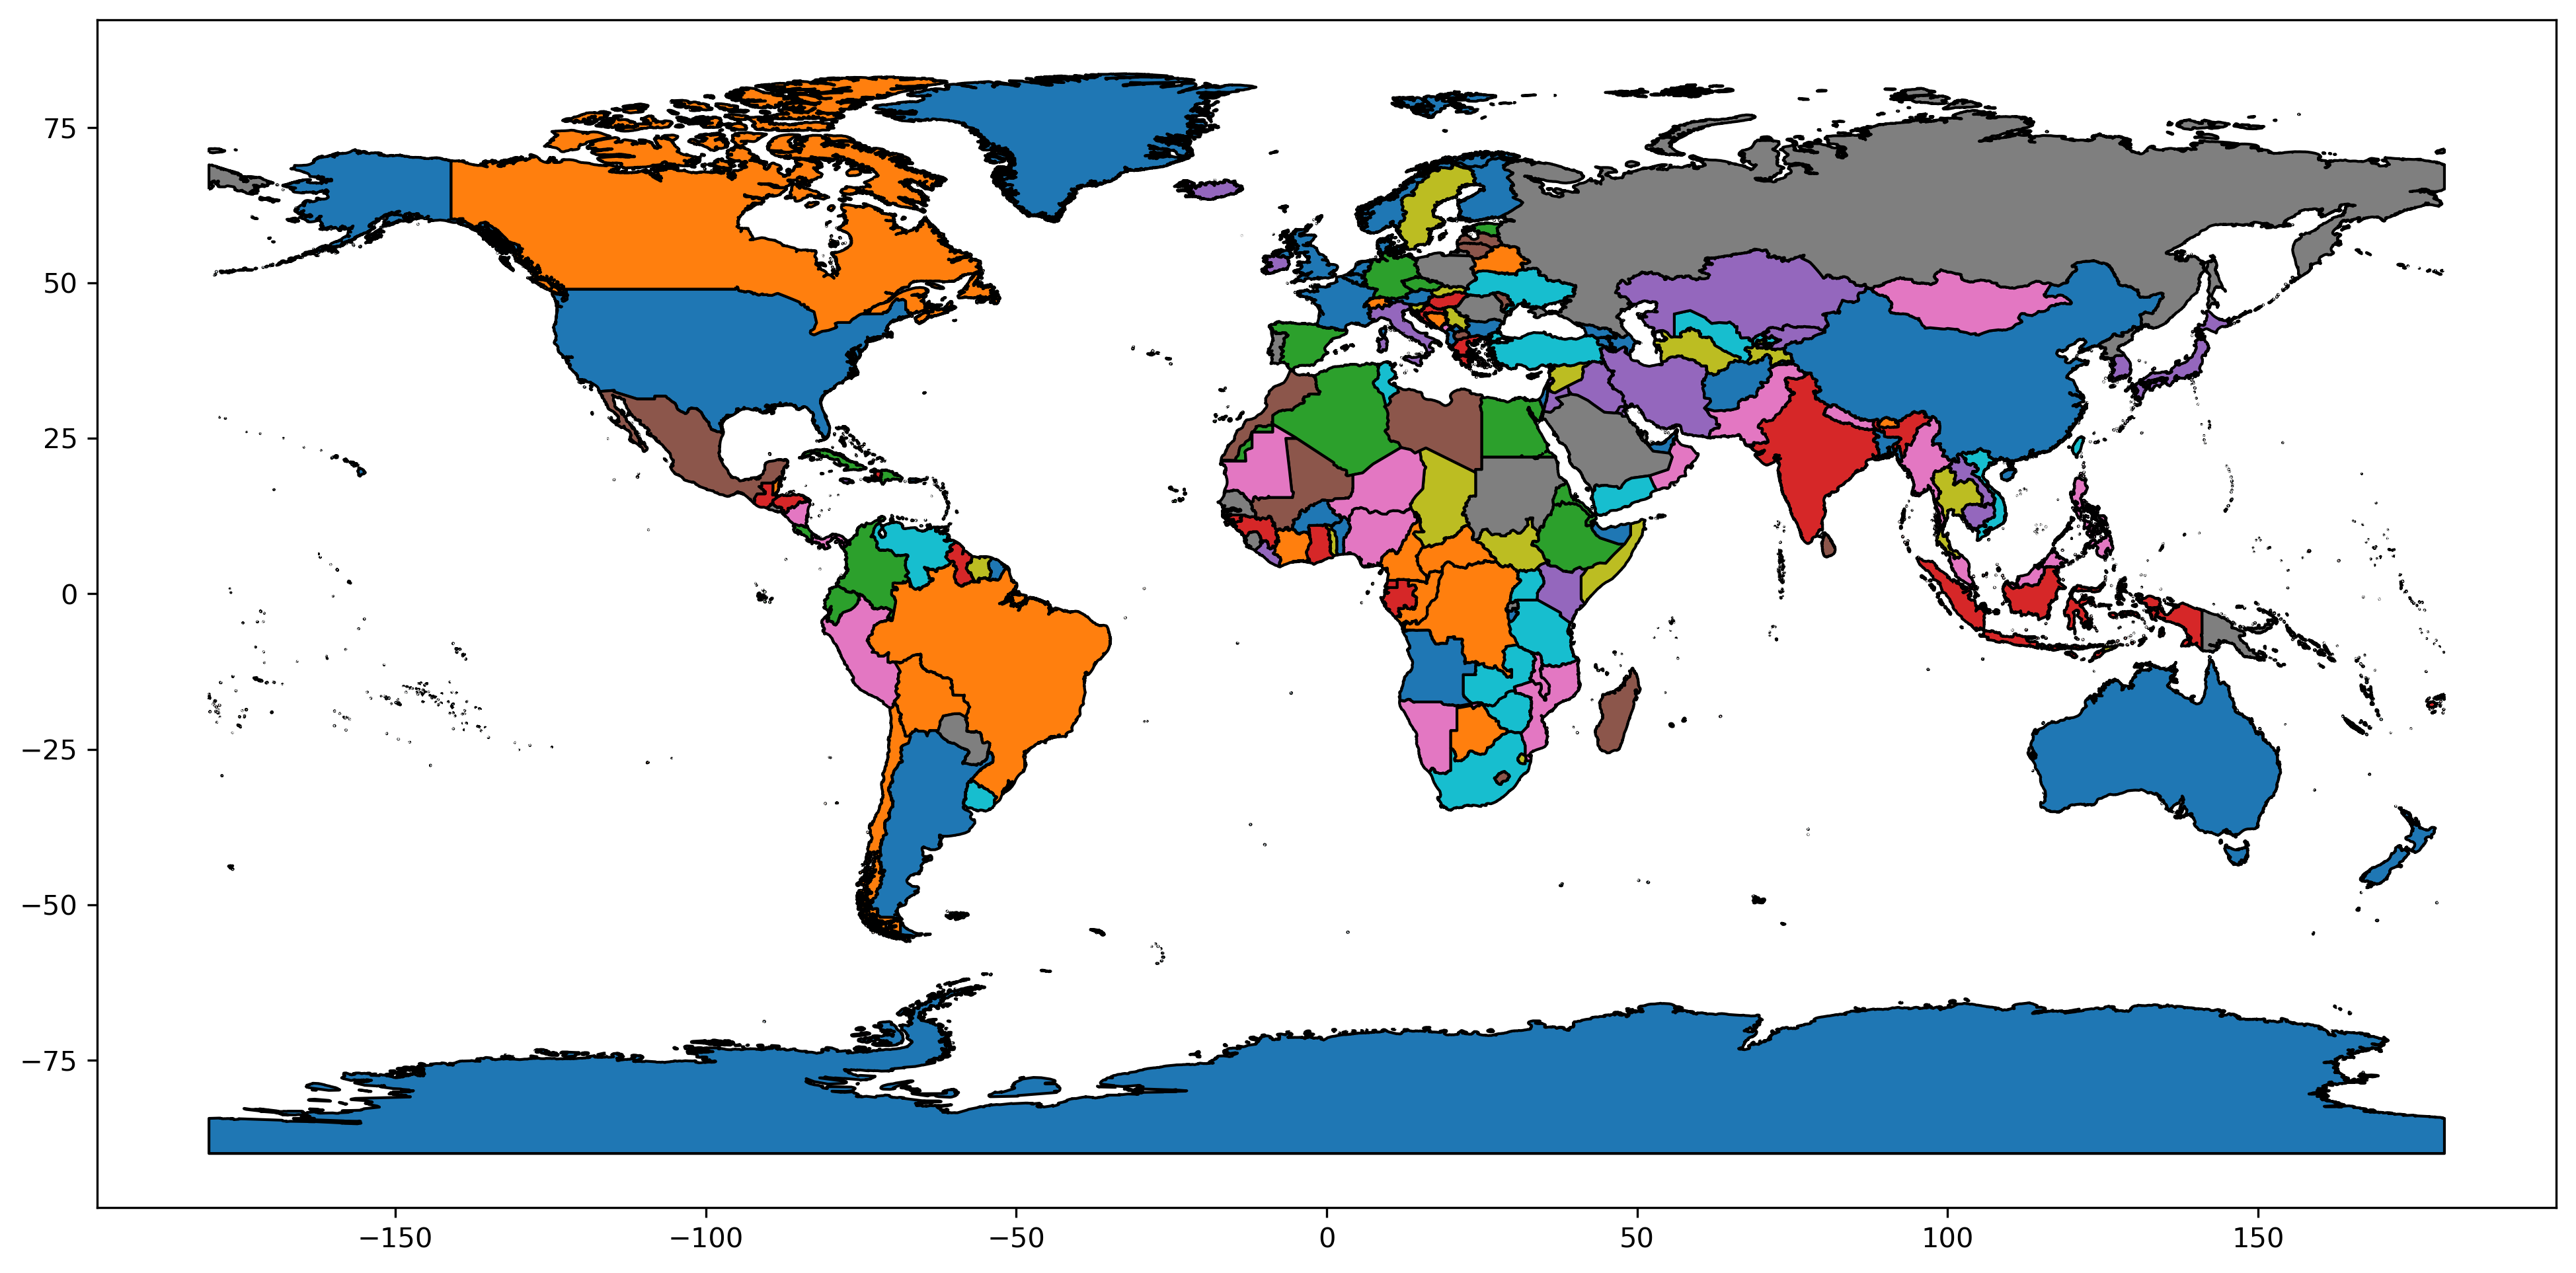

In [52]:
#Take a look:
#####

fig1, ax1 = plt.subplots(1, 1, figsize=(16,12), dpi=300)

#Color by effectively random color:
gdf.plot(ax=ax1, column='ISO_A3', edgecolor='black');

## Let's grab the most recent 2017 emissions data, and try to merge:

- `ADMIN` gives country name in our natural earth data
- `Nation` in the emissions DataFrame

In [53]:
#2017 Data:
######

df_2017 = df.loc[df.Year == 2017]

In [55]:
#Note we have 218 observations here, but only 201 sovereign countries above
df_2017.loc[df_2017.Total > 0].shape

(218, 17)

In [56]:
#See what our emissions total for 2017 is (in GtC):
####

df_2017.loc[df_2017.Total > 0].Total.sum() / 1e6

9.231495

In [57]:
#What do our country names look like? gdf.ADMIN and df_2017.Nation
#Our map:
gdf.ADMIN.sort_values()

125       Afghanistan
60            Albania
117           Algeria
124           Andorra
97             Angola
            ...      
26     Western Sahara
156             Yemen
77             Zambia
103          Zimbabwe
119          eSwatini
Name: ADMIN, Length: 209, dtype: object

In [58]:
#Our Emissions:
df_2017.Nation.sort_values()

266                                         AFGHANISTAN
533                                             ALBANIA
800                                             ALGERIA
1067                                            ANDORRA
1334                                             ANGOLA
                              ...                      
68084    YUGOSLAVIA (FORMER SOCIALIST FEDERAL REPUBLIC)
68351                  YUGOSLAVIA (MONTENEGRO & SERBIA)
68618                                            ZAMBIA
68885                                          ZANZIBAR
69152                                          ZIMBABWE
Name: Nation, Length: 259, dtype: object

In [59]:
#Now let's try to merge with gdf:
######

#First, let's upper the nation names in both datasets...
df_2017.Nation = df_2017.Nation.str.upper()

gdf.ADMIN = gdf.ADMIN.str.upper()


#Now merge: Do a LEFT join (remember, the default is "inner")
carbon_gdf = gdf.merge(df_2017, how="left", left_on='ADMIN', right_on='Nation')

#Take a quick looksie:
carbon_gdf

featurecla  scalerank  LABELRANK                    SOVEREIGNT  \
0    Admin-0 sovereignty          5          2                     Indonesia   
1    Admin-0 sovereignty          5          3                      Malaysia   
2    Admin-0 sovereignty          0          2                         Chile   
3    Admin-0 sovereignty          0          3                       Bolivia   
4    Admin-0 sovereignty          0          2                          Peru   
..                   ...        ...        ...                           ...   
204  Admin-0 sovereignty          5          4                       Bahrain   
205  Admin-0 sovereignty          6          6               Spratly Islands   
206  Admin-0 sovereignty          6          8  Bajo Nuevo Bank (Petrel Is.)   
207  Admin-0 sovereignty          6          5               Serranilla Bank   
208  Admin-0 sovereignty          6          6              Scarborough Reef   

    SOV_A3  ADM0_DIF  LEVEL               TYPE TLC  \
0      IDN         0      2  Sovereign country   1   
1      MYS         0      2  Sovereign country   1   
2      CHL         0      2  Sovereign country   1   
3      BOL         0      2  Sovereign country   1   
4      PER         0      2  Sovereign country   1   
..     ...       ...    ...                ...  ..   
204    BHR         0      2  Sovereign country   1   
205    PGA         0      2      Indeterminate   1   
206    BJN         0      2      Indeterminate   1   
207    SER         0      2      Indeterminate   1   
208    SCR         0      2      Indeterminate   1   

                            ADMIN  ... Flaring  Per_Capita  Bunker   Total_C  \
0                       INDONESIA  ...  3014.0        0.54  1106.0  3.335147   
1                        MALAYSIA  ...  2446.0        2.18  2467.0  1.376270   
2                           CHILE  ...     8.0        1.25   616.0  0.727260   
3                         BOLIVIA  ...     NaN         NaN     NaN       NaN   
4                            PERU  ...    46.0        0.45   837.0  0.485311   
..                            ...  ...     ...         ...     ...       ...   
204                       BAHRAIN  ...     0.0        6.00   382.0  0.225462   
205               SPRATLY ISLANDS  ...     NaN         NaN     NaN       NaN   
206  BAJO NUEVO BANK (PETREL IS.)  ...     NaN         NaN     NaN       NaN   
207               SERRANILLA BANK  ...     NaN         NaN     NaN       NaN   
208              SCARBOROUGH REEF  ...     NaN         NaN     NaN       NaN   

      Solid_C  Liquid_C     Gas_C  Cement_C Flaring_C  Bunker_C  
0    0.717693  1.760209  0.598907  0.132688  0.125650  0.036048  
1    0.225447  0.617639  0.403237  0.058839  0.071103  0.037174  
2    0.224217  0.388357  0.074999  0.018229  0.021452  0.026363  
3         NaN       NaN       NaN       NaN       NaN       NaN  
4    0.030093  0.354135  0.052653  0.024675  0.023766  0.014200  
..        ...       ...       ...       ...       ...       ...  
204  0.000042  0.055700  0.168051  0.001669  0.000000  0.030828  
205       NaN       NaN       NaN       NaN       NaN       NaN  
206       NaN       NaN       NaN       NaN       NaN       NaN  
207       NaN       NaN       NaN       NaN       NaN       NaN  
208       NaN       NaN       NaN       NaN       NaN       NaN  

[209 rows x 186 columns]

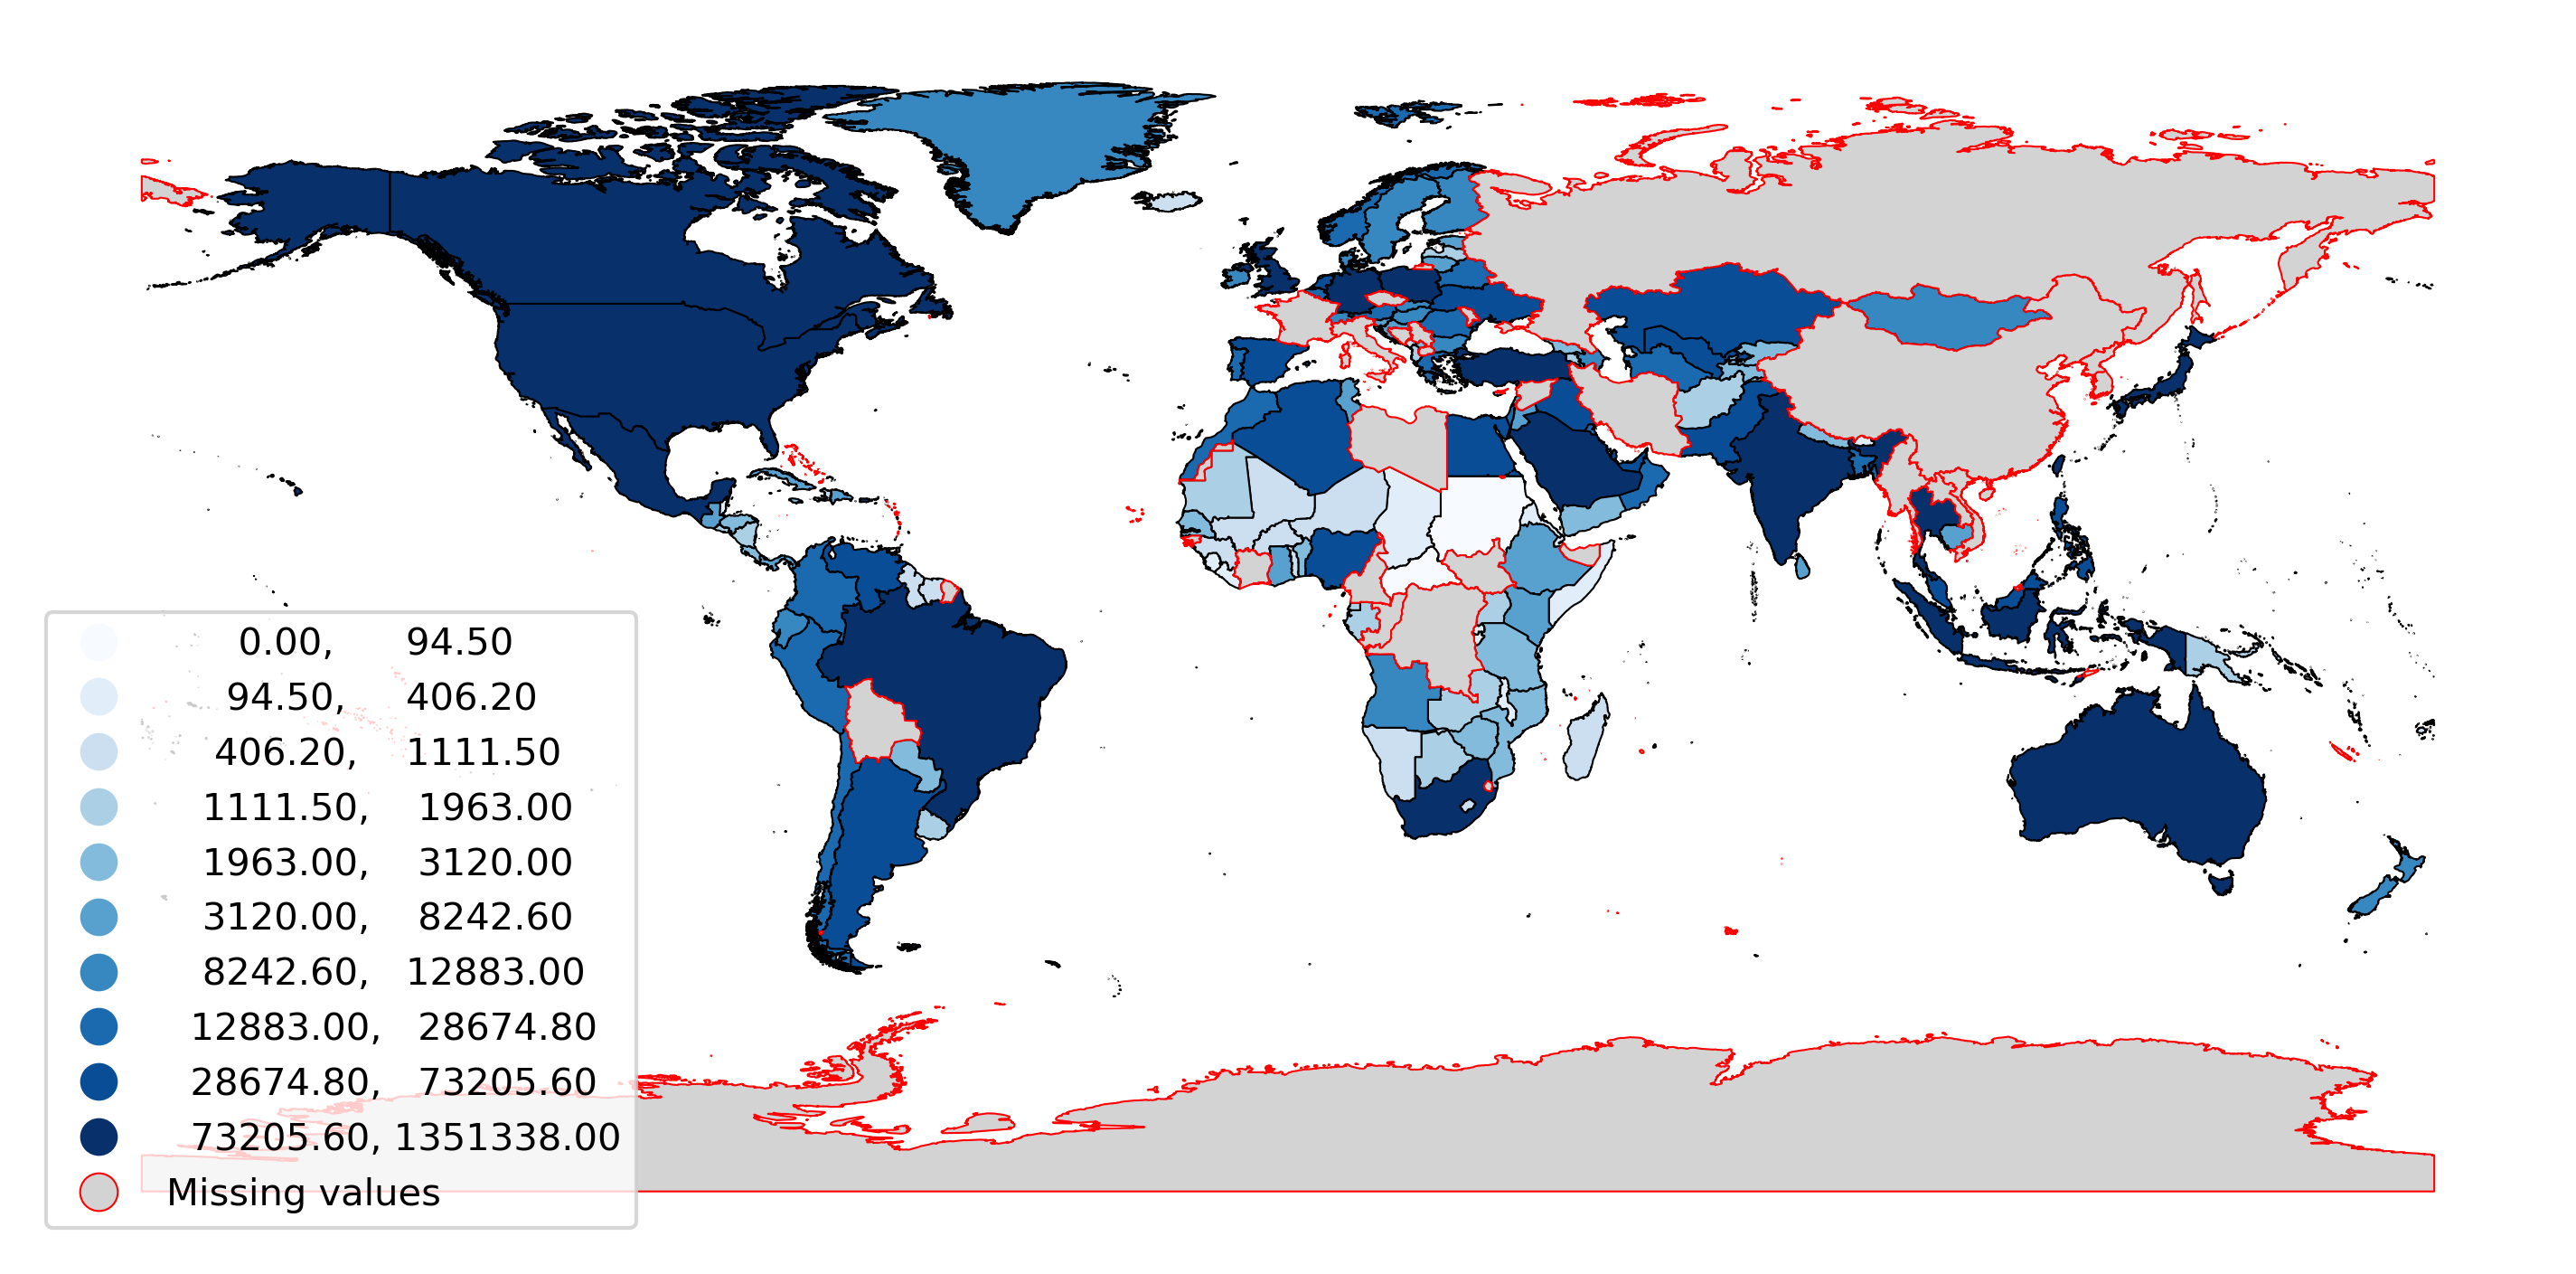

In [60]:
#And let's see what we ended up with...
#Plot by Total emissions in 2017

fig, ax1 = plt.subplots(1,1, figsize=(12, 8), dpi=300)

carbon_gdf.plot(ax = ax1, column = 'Total', scheme="quantiles", k=10, cmap='Blues', edgecolor='black', linewidth=.5,
           missing_kwds={"color": "lightgrey", "edgecolor": "red", "label": "Missing values"},
           legend = True, legend_kwds={'loc': 'lower left'})
    
ax1.set_axis_off()

We did okay, but obviously missed a lot of countries. Let's get the ISO A3 codes for all the countries and merge based on this...

In [61]:
###To deal with this:

###Get all countries with emissions in 2017, and save their names:
df2 = df.loc[(df['Year'] == 2017)]
df2 = df2.loc[df2['Total'] > 0]

#The Nation names we want:
df2[['Nation']].head()

#And now let's write our variables of interest to a csv file:
#Note: We don't write the index
#df2[['Nation']].to_csv('CDIAC_Nations_ISO.csv', index=False)

#Let's map the names in the CDIAC-FF dataframe to ISO A3 codes
#Your intrepid instructor already did this...

Nation
266   AFGHANISTAN
533       ALBANIA
800       ALGERIA
1067      ANDORRA
1334       ANGOLA

In [62]:
#Now load back up, with the ISO A3 codes added, and merge to the 2017 DataFrame:

iso_map = pd.read_csv('CDIAC_Nations_ISO.csv')
iso_map.head()

Nation iso_a3
0  AFGHANISTAN    AFG
1      ALBANIA    ALB
2      ALGERIA    DZA
3      ANDORRA    AND
4       ANGOLA    AGO

In [63]:
#Merge with df_2017: Do an INNER join: Only keep stuff with a Nation and ISO code

df_iso = df_2017.merge(iso_map[['Nation', 'iso_a3']], how="inner", on="Nation")

df_iso


Nation  Year    Total    Solid   Liquid      Gas  \
0                  AFGHANISTAN  2017   1879.0    941.0    837.0     82.0   
1                      ALBANIA  2017   1475.0    120.0   1119.0     23.0   
2                      ALGERIA  2017  42246.0    217.0  15113.0  22476.0   
3                      ANDORRA  2017    127.0      0.0    127.0      0.0   
4                       ANGOLA  2017  10231.0      0.0   5493.0    429.0   
..                         ...   ...      ...      ...      ...      ...   
213                   VIET NAM  2017  50156.0  21201.0  15545.0   4879.0   
214  WALLIS AND FUTUNA ISLANDS  2017      7.0      0.0      7.0      0.0   
215                      YEMEN  2017   2729.0     92.0   2115.0    323.0   
216                     ZAMBIA  2017   1718.0    519.0    975.0      0.0   
217                   ZIMBABWE  2017   2824.0   1742.0    896.0      0.0   

     Cement  Flaring  Per_Capita  Bunker   Total_C   Solid_C  Liquid_C  \
0      19.0      0.0        0.05     9.0  0.043790  0.011332  0.024874   
1     213.0      0.0        0.51    31.0  0.074103  0.017926  0.047119   
2    2865.0   1575.0        1.02   505.0  1.121349  0.030826  0.391192   
3       0.0      0.0        1.65     0.0  0.003714  0.000000  0.003714   
4     533.0   3776.0        0.34   549.0  0.173706  0.000437  0.084370   
..      ...      ...         ...     ...       ...       ...       ...   
213  8531.0      0.0        0.53   918.0  0.824900  0.377556  0.278677   
214     0.0      0.0        0.56     1.0  0.000117  0.000000  0.000117   
215   199.0      0.0        0.10    96.0  0.117293  0.001051  0.107520   
216   224.0      0.0        0.10    22.0  0.046292  0.017411  0.025388   
217   186.0      0.0        0.20    52.0  0.185294  0.145647  0.034695   

        Gas_C  Cement_C  Flaring_C  Bunker_C iso_a3  
0    0.005249  0.000709   0.001625  0.000320    AFG  
1    0.004383  0.004679   0.000000  0.000490    ALB  
2    0.489710  0.053553   0.156079  0.030038    DZA  
3    0.000000  0.000000   0.000000  0.000000    AND  
4    0.009985  0.006613   0.072307  0.018431    AGO  
..        ...       ...        ...       ...    ...  
213  0.066112  0.102343   0.000217  0.011831    VNM  
214  0.000000  0.000000   0.000000  0.000016    WLF  
215  0.003665  0.005056   0.000000  0.004861    YEM  
216  0.000000  0.003496   0.000000  0.001382    ZMB  
217  0.000000  0.004959   0.000000  0.001883    ZWE  

[218 rows x 18 columns]

In [64]:
#Let's pre-emptively alter Israel and Kosovo before merging:
#######

gdf['ISO_A3_EH'].loc[gdf.ADMIN == 'ISRAEL'] = 'ISR'
gdf['ISO_A3_EH'].loc[gdf.ADMIN == 'KOSOVO'] = 'KOS'

In [65]:
#And the merge!
#####

carbon_gdf = gdf.merge(df_iso, how="left", left_on='ISO_A3_EH', right_on='iso_a3')

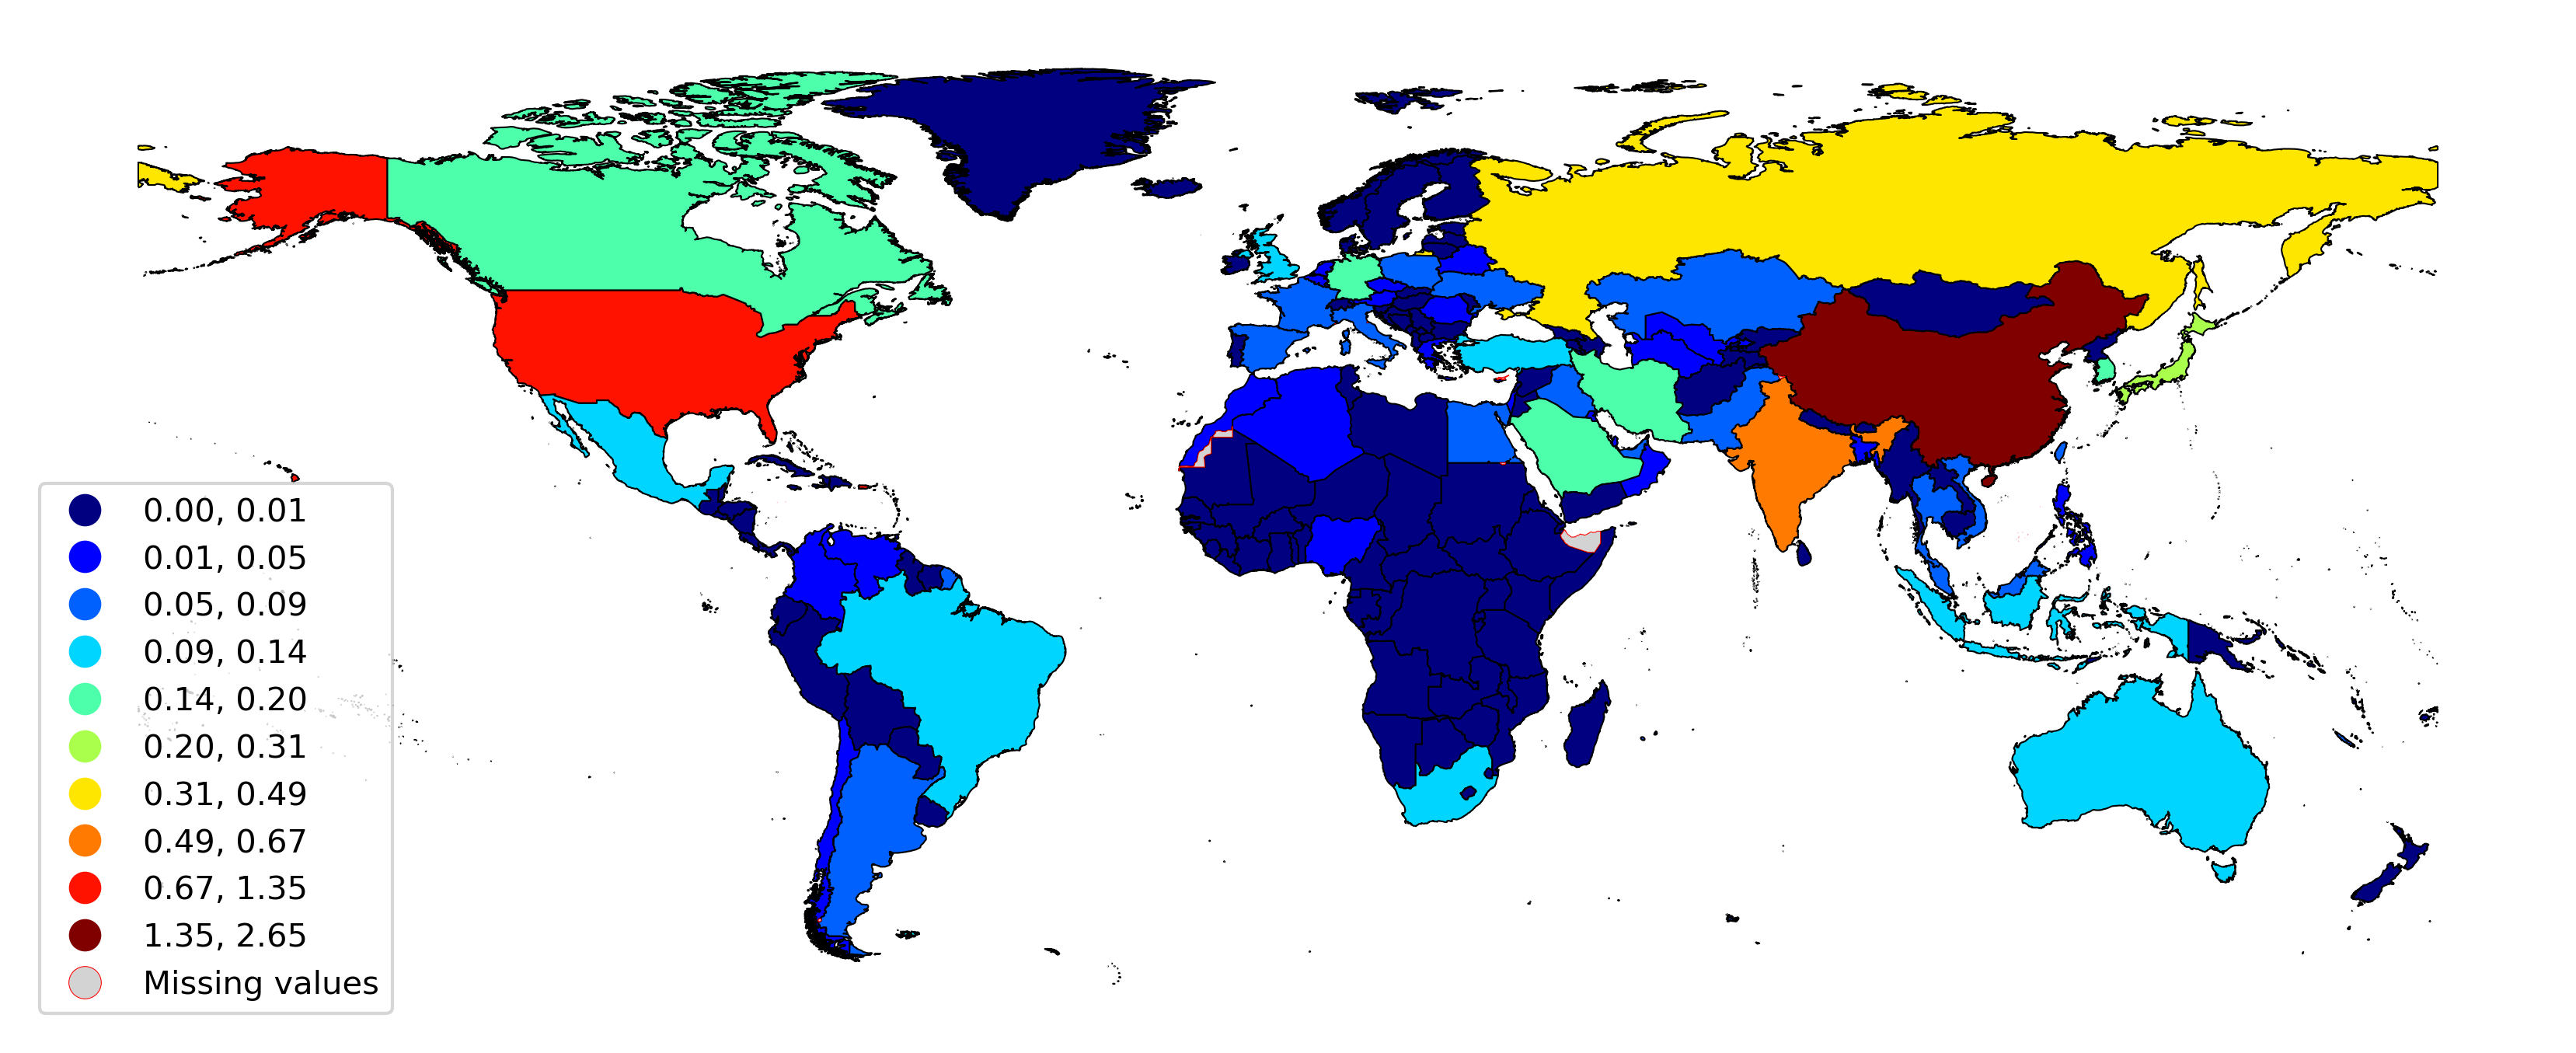

In [66]:
#And plot:

#Let's preempitely drop Antarctica:
carbon_gdf = carbon_gdf.loc[carbon_gdf['ADMIN'] != 'ANTARCTICA']


#Plot by Total emissions in 2017
fig, ax1 = plt.subplots(1,1, figsize=(14, 8), dpi=300)

#Note we use a Fisher-Jenks scheme here:
carbon_gdf.plot(ax = ax1, column = carbon_gdf.Total/1e6, scheme="fisherjenks", k=10, cmap='jet', edgecolor='black', linewidth=.5,
           missing_kwds={"color": "lightgrey", "edgecolor": "red", "label": "Missing values", "linewidth":.25},
           legend = True, legend_kwds={'loc': 'lower left'})
    
ax1.set_axis_off()

#### There are still some missing values, what did we miss?

In [67]:
#What is missing??
#########

carbon_gdf.loc[carbon_gdf.Total.isna()]

featurecla  scalerank  LABELRANK                     SOVEREIGNT  \
19   Admin-0 sovereignty          0          5                     Somaliland   
26   Admin-0 sovereignty          0          7                 Western Sahara   
107  Admin-0 sovereignty          0          6                     San Marino   
116  Admin-0 sovereignty          0          6                         Monaco   
160  Admin-0 sovereignty          0          6                        Vatican   
161  Admin-0 sovereignty          1          6                Northern Cyprus   
162  Admin-0 sovereignty          1          9            Cyprus No Mans Area   
163  Admin-0 sovereignty          0          5                        Kashmir   
164  Admin-0 sovereignty          0          9  Southern Patagonian Ice Field   
165  Admin-0 sovereignty          0          8                      Bir Tawil   
205  Admin-0 sovereignty          6          6                Spratly Islands   
206  Admin-0 sovereignty          6          8   Bajo Nuevo Bank (Petrel Is.)   
207  Admin-0 sovereignty          6          5                Serranilla Bank   
208  Admin-0 sovereignty          6          6               Scarborough Reef   

    SOV_A3  ADM0_DIF  LEVEL               TYPE  TLC  \
19     SOL         0      2  Sovereign country    1   
26     SAH         0      2      Indeterminate    1   
107    SMR         0      2  Sovereign country    1   
116    MCO         0      2  Sovereign country    1   
160    VAT         0      2  Sovereign country    1   
161    CYN         0      2  Sovereign country    1   
162    CNM         0      2      Indeterminate  NaN   
163    KAS         0      2      Indeterminate  NaN   
164    SPI         0      2      Indeterminate  NaN   
165    BRT         0      2      Indeterminate  NaN   
205    PGA         0      2      Indeterminate    1   
206    BJN         0      2      Indeterminate    1   
207    SER         0      2      Indeterminate    1   
208    SCR         0      2      Indeterminate    1   

                             ADMIN  ... Per_Capita  Bunker Total_C Solid_C  \
19                      SOMALILAND  ...        NaN     NaN     NaN     NaN   
26                  WESTERN SAHARA  ...        NaN     NaN     NaN     NaN   
107                     SAN MARINO  ...        NaN     NaN     NaN     NaN   
116                         MONACO  ...        NaN     NaN     NaN     NaN   
160                        VATICAN  ...        NaN     NaN     NaN     NaN   
161                NORTHERN CYPRUS  ...        NaN     NaN     NaN     NaN   
162            CYPRUS NO MANS AREA  ...        NaN     NaN     NaN     NaN   
163                SIACHEN GLACIER  ...        NaN     NaN     NaN     NaN   
164  SOUTHERN PATAGONIAN ICE FIELD  ...        NaN     NaN     NaN     NaN   
165                      BIR TAWIL  ...        NaN     NaN     NaN     NaN   
205                SPRATLY ISLANDS  ...        NaN     NaN     NaN     NaN   
206   BAJO NUEVO BANK (PETREL IS.)  ...        NaN     NaN     NaN     NaN   
207                SERRANILLA BANK  ...        NaN     NaN     NaN     NaN   
208               SCARBOROUGH REEF  ...        NaN     NaN     NaN     NaN   

     Liquid_C Gas_C Cement_C  Flaring_C Bunker_C iso_a3  
19        NaN   NaN      NaN        NaN      NaN    NaN  
26        NaN   NaN      NaN        NaN      NaN    NaN  
107       NaN   NaN      NaN        NaN      NaN    NaN  
116       NaN   NaN      NaN        NaN      NaN    NaN  
160       NaN   NaN      NaN        NaN      NaN    NaN  
161       NaN   NaN      NaN        NaN      NaN    NaN  
162       NaN   NaN      NaN        NaN      NaN    NaN  
163       NaN   NaN      NaN        NaN      NaN    NaN  
164       NaN   NaN      NaN        NaN      NaN    NaN  
165       NaN   NaN      NaN        NaN      NaN    NaN  
205       NaN   NaN      NaN        NaN      NaN    NaN  
206       NaN   NaN      NaN        NaN      NaN    NaN  
207       NaN   NaN      NaN        NaN      Na

- How much carbon did we get?
- How much is missing?

In [68]:
#Got ALMOST Everything
carbon_gdf.Total.sum() / 1e6

9.346235

In [69]:
#And how much carbon is missing?
df_iso.loc[~df_iso.iso_a3.isin(carbon_gdf.iso_a3)].Total.sum() / 1e6


0.017771

#### Another Plot: Total Cumulative Emissions in 2017

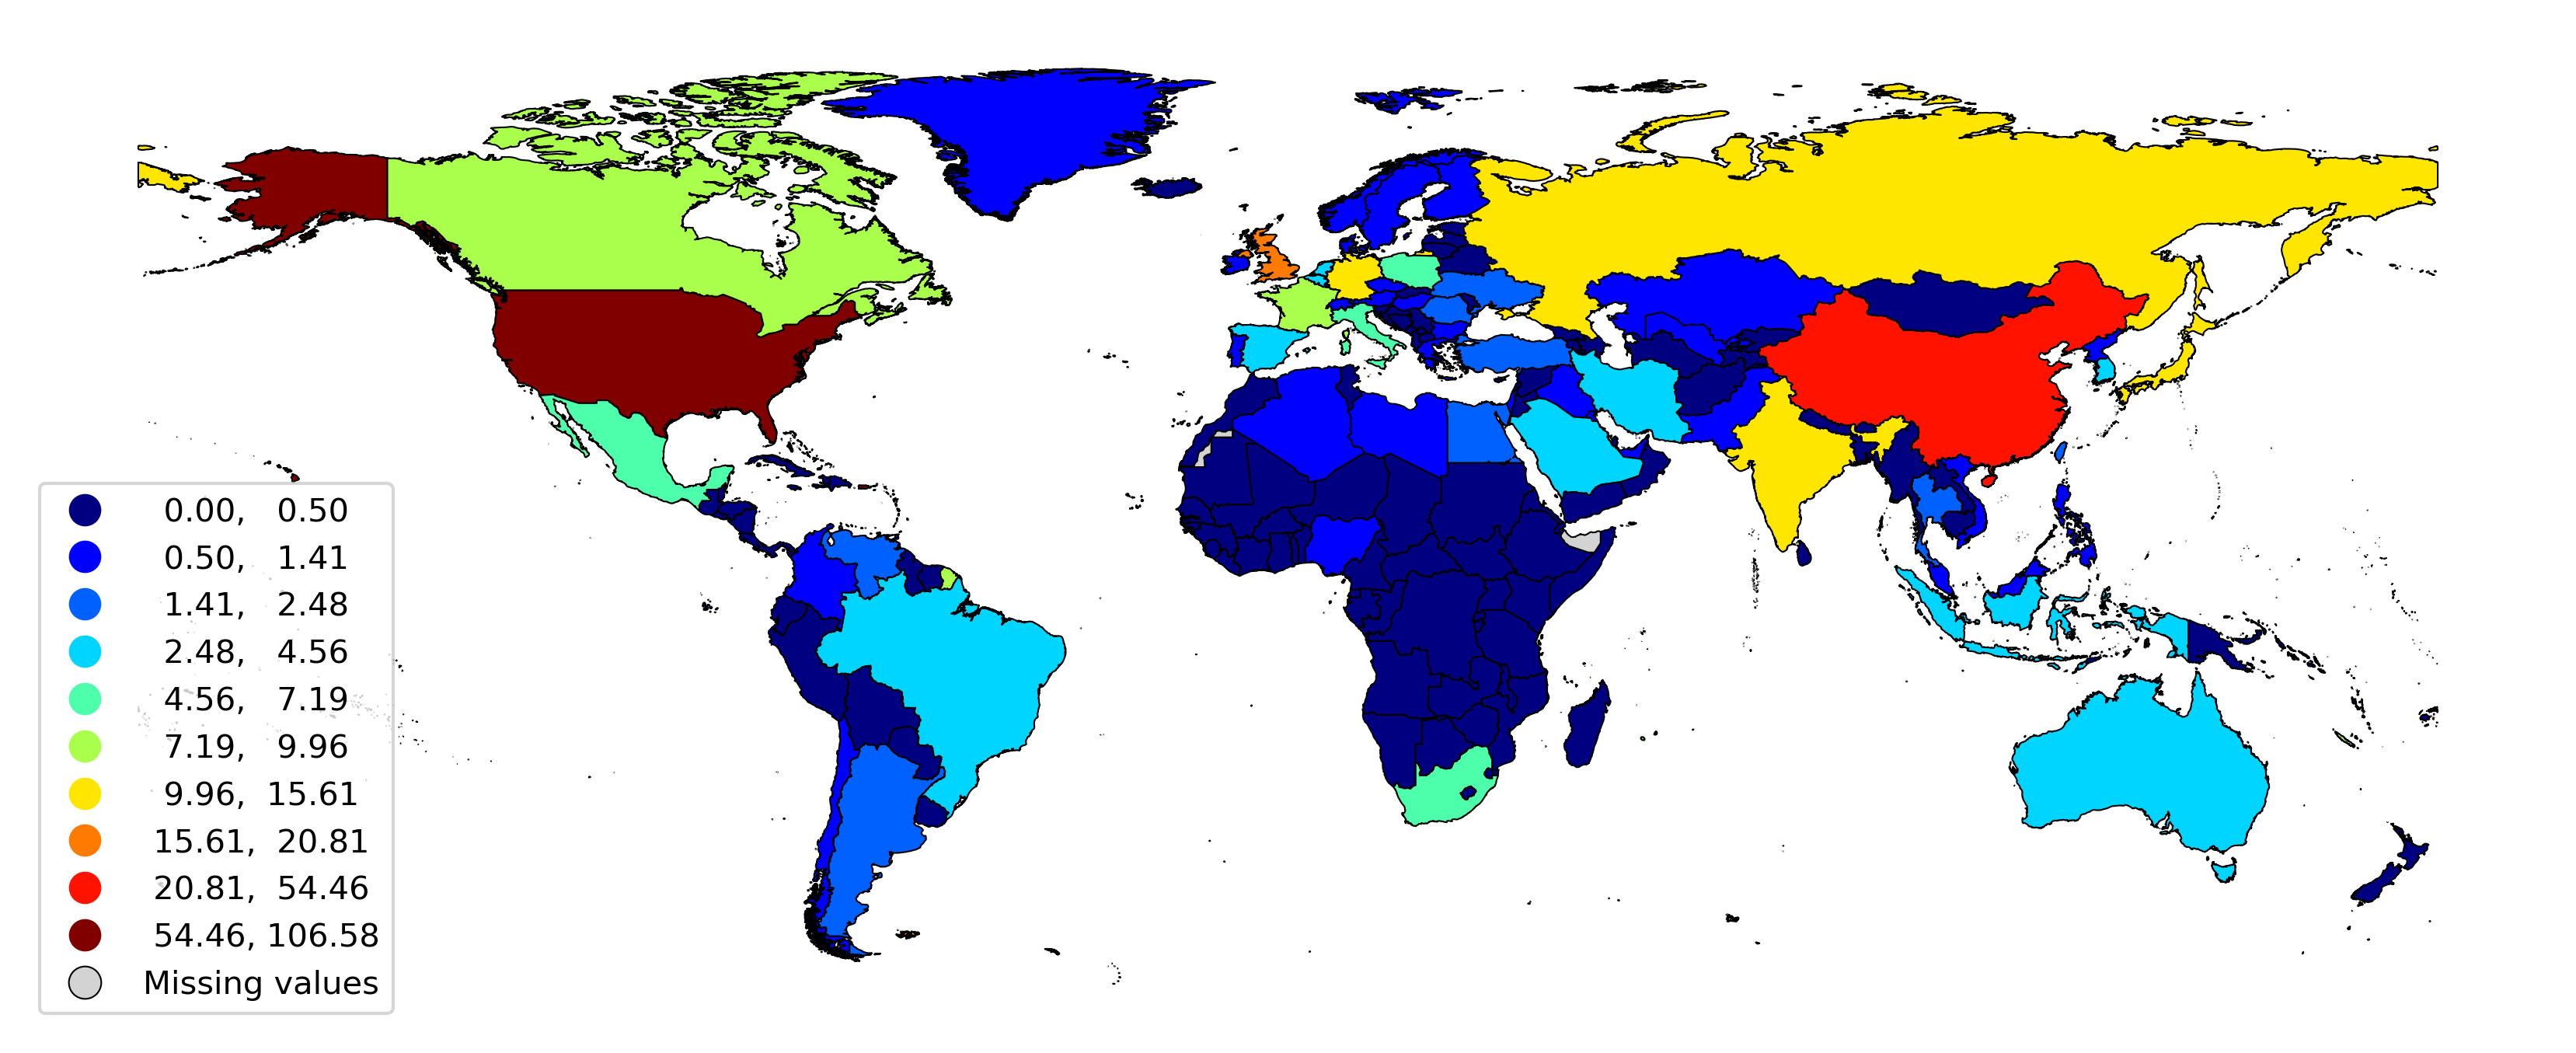

In [70]:
#Another plot: Total CUMULATIVE Emissions in 2017
###############

fig, ax1 = plt.subplots(1,1, figsize=(14, 8), dpi=300)

carbon_gdf.plot(ax = ax1, column = 'Total_C', scheme="fisherjenks", k=10, cmap='jet', edgecolor='black', linewidth=.5,
           missing_kwds={"color": "lightgrey", "label": "Missing values", "linewidth":.5},
           legend = True, legend_kwds={'loc': 'lower left'})
    
ax1.set_axis_off()

#### And investigate per-capita emissions

In [71]:
#Exclude anything with no population:
carbon_gdf = carbon_gdf.loc[carbon_gdf.POP_EST > 0]

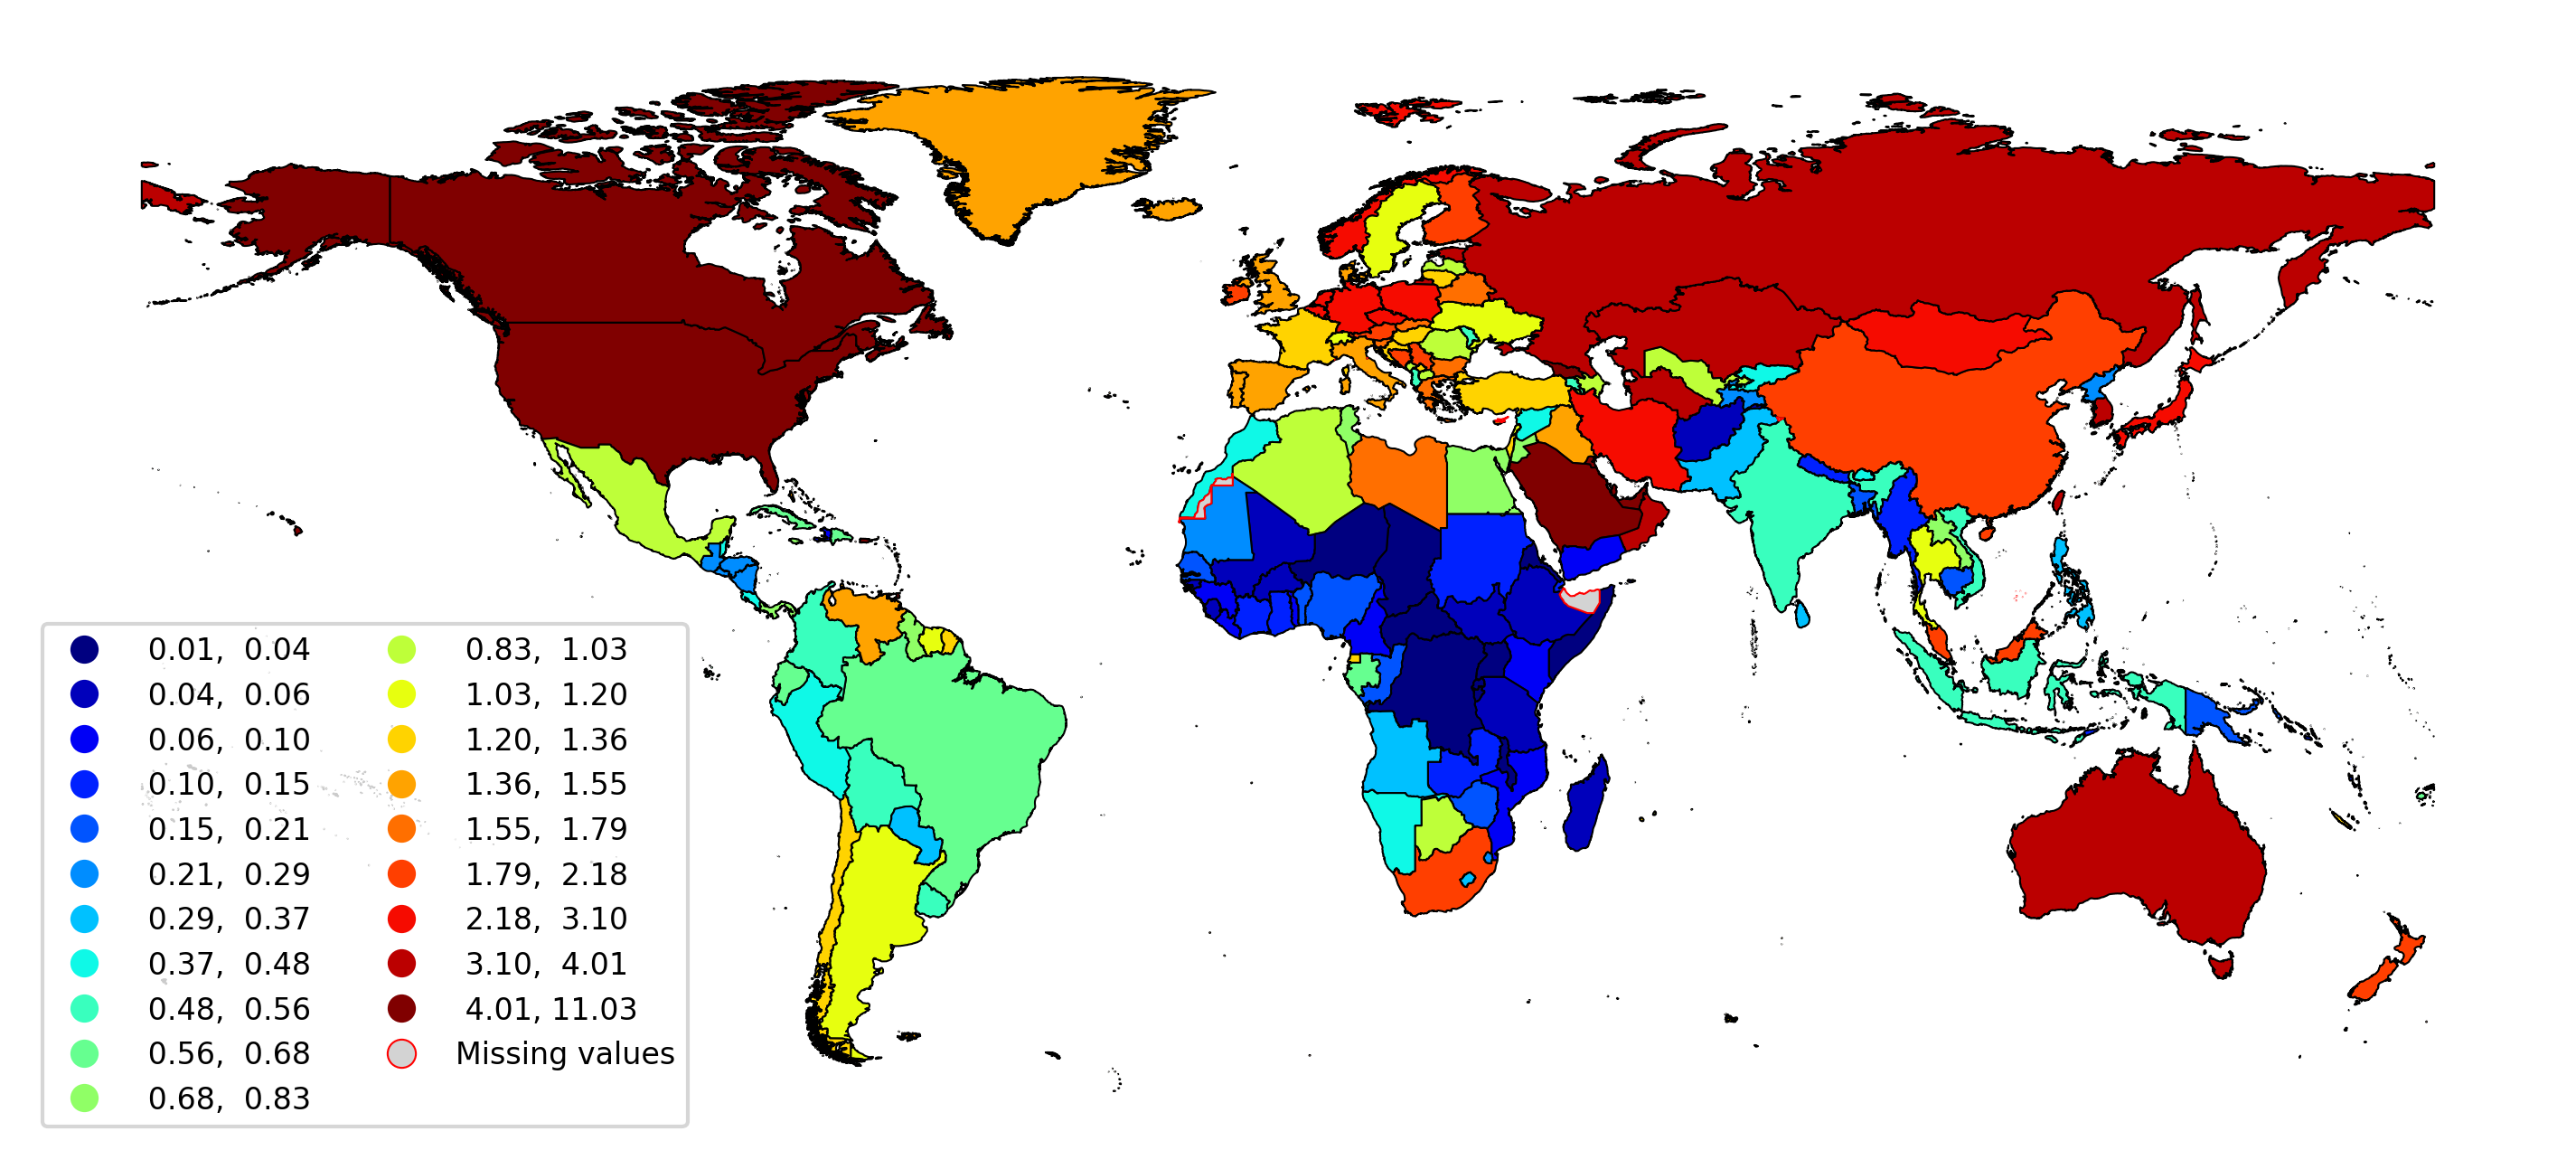

In [72]:
#### Per Capita Emissions?
#####

#Natural Earth comes with population and gpd estimates
#We can get more from World Bank, etc., but stick with this for now:

fig, ax1 = plt.subplots(1,1, figsize=(12, 8), dpi=300)

carbon_gdf.plot(ax = ax1, column = carbon_gdf.Total / carbon_gdf.POP_EST*1e3, linewidth=.5,
           scheme="quantiles", k=20, cmap='jet', edgecolor='black', legend=True,
           legend_kwds={'loc': 'lower left', 'fontsize':8, 'markerscale':.75, 'ncol':2},
           missing_kwds={"color": "lightgrey", "edgecolor": "red", "label": "Missing values"})

ax1.set_axis_off()

In [73]:
## Note: The population for Georgia is incorrect, let's fix it here:
carbon_gdf['POP_EST'].loc[carbon_gdf.Nation == 'GEORGIA'] = 3.7e6

In [74]:
#Make a new column for per capita emissions, and see who the worst offenders are: 
carbon_gdf['PC'] = carbon_gdf.Total / carbon_gdf.POP_EST * 1e3

In [75]:
#Highest per-capita emissions?
carbon_gdf.sort_values(by='PC', ascending=False)[['Nation', 'PC', 'POP_EST']].head(20)

Nation         PC      POP_EST
100                     QATAR  10.182669    2832067.0
180       TRINIDAD AND TOBAGO   7.814488    1394973.0
111                    KUWAIT   6.806141    4207083.0
115       BRUNEI (DARUSSALAM)   6.074524     433285.0
204                   BAHRAIN   5.459513    1641172.0
56       UNITED ARAB EMIRATES   5.251609    9770529.0
101              SAUDI ARABIA   4.560044   34268528.0
149                    CANADA   4.150707   37589262.0
148  UNITED STATES OF AMERICA   4.075261  331595460.0
55                 LUXEMBOURG   3.971634     619896.0
167                 AUSTRALIA   3.937227   25368867.0
39                 KAZAKHSTAN   3.614306   18513930.0
37                       OMAN   3.603829    4974986.0
48                    ESTONIA   3.564779    1326590.0
203                     PALAU   3.498445      18008.0
45         RUSSIAN FEDERATION   3.418473  144373535.0
23          REPUBLIC OF KOREA   3.267085   51709098.0
137              TURKMENISTAN   3.233038    5942089.0
174                    TAIWAN   3.151384   23568378.0
44                   MONGOLIA   2.896904    3225167.0

### Save Maps?

- Can save as shapefile

- Can also save attributes as csv, etc. separately

- Save just the geometries as shapefile

In [76]:
#Recall we have:
carbon_gdf

featurecla  scalerank  LABELRANK  \
0    Admin-0 sovereignty          5          2   
1    Admin-0 sovereignty          5          3   
2    Admin-0 sovereignty          0          2   
3    Admin-0 sovereignty          0          3   
4    Admin-0 sovereignty          0          2   
..                   ...        ...        ...   
201  Admin-0 sovereignty          5          6   
202  Admin-0 sovereignty          5          4   
203  Admin-0 sovereignty          6          6   
204  Admin-0 sovereignty          5          4   
205  Admin-0 sovereignty          6          6   

                         SOVEREIGNT SOV_A3  ADM0_DIF  LEVEL  \
0                         Indonesia    IDN         0      2   
1                          Malaysia    MYS         0      2   
2                             Chile    CHL         0      2   
3                           Bolivia    BOL         0      2   
4                              Peru    PER         0      2   
..                              ...    ...       ...    ...   
201  Federated States of Micronesia    FSM         0      2   
202                         Vanuatu    VUT         0      2   
203                           Palau    PLW         0      2   
204                         Bahrain    BHR         0      2   
205                 Spratly Islands    PGA         0      2   

                  TYPE TLC                           ADMIN  ...  Bunker  \
0    Sovereign country   1                       INDONESIA  ...  1106.0   
1    Sovereign country   1                        MALAYSIA  ...  2467.0   
2    Sovereign country   1                           CHILE  ...   616.0   
3    Sovereign country   1                         BOLIVIA  ...    68.0   
4    Sovereign country   1                            PERU  ...   837.0   
..                 ...  ..                             ...  ...     ...   
201  Sovereign country   1  FEDERATED STATES OF MICRONESIA  ...     8.0   
202  Sovereign country   1                         VANUATU  ...    10.0   
203  Sovereign country   1                           PALAU  ...    13.0   
204  Sovereign country   1                         BAHRAIN  ...   382.0   
205      Indeterminate   1                 SPRATLY ISLANDS  ...     NaN   

      Total_C   Solid_C  Liquid_C     Gas_C  Cement_C Flaring_C  Bunker_C  \
0    3.335147  0.717693  1.760209  0.598907  0.132688  0.125650  0.036048   
1    1.376270  0.225447  0.617639  0.403237  0.058839  0.071103  0.037174   
2    0.727260  0.224217  0.388357  0.074999  0.018229  0.021452  0.026363   
3    0.125241  0.000064  0.073097  0.037803  0.005848  0.008435  0.001106   
4    0.485311  0.030093  0.354135  0.052653  0.024675  0.023766  0.014200   
..        ...       ...       ...       ...       ...       ...       ...   
201  0.000894  0.000000  0.000894  0.000000  0.000000  0.000000  0.000080   
202  0.001150  0.000042  0.001108  0.000000  0.000000  0.000000  0.000386   
203  0.001505  0.000000  0.001505  0.000000  0.000000  0.000000  0.000340   
204  0.225462  0.000042  0.055700  0.168051  0.001669  0.000000  0.030828   
205       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

    iso_a3        PC  
0      IDN  0.531158  
1      MYS  2.118419  
2      CHL  1.220396  
3      BOL  0.515239  
4      PER  0.438444  
..     ...       ...  
201    FSM  0.342661  
202    VUT  0.126717  
203    PLW  3.498445  
204    BHR  5.459513  
205    NaN       NaN  

[202 rows x 188 columns]

In [77]:
#Let's save these results:
###############

carbon_gdf.to_file('Data/Emissions_Map_2017/Emissions_Map_2017.shp')
